<a href="https://colab.research.google.com/github/ayanoglu/REDGPA/blob/DNN/REDGPAmain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from numpy import array
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import pandas as pd
import numpy as np
np.set_printoptions(linewidth=160)
import tensorflow as tf
import csv
import math
import matplotlib.pyplot as plt
from decimal import *
from google.colab import files
import plotly.graph_objects as go
import plotly.express as px
import itertools
from itertools import combinations
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import io

uploaded = files.upload()

Saving Survey_numerical_score_GPA.csv to Survey_numerical_score_GPA.csv


In [2]:
DF = pd.read_csv(io.BytesIO(uploaded['Survey_numerical_score_GPA.csv']), header=None, skip_blank_lines=True)

In [3]:
DF.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43
0,6,6,6,6,6,6,7,5,3,3,5,5,6,4,4,6,5,7,6,6,6,3,5,5,4,5,5,5,6,5,5,1,1,1,1,1,3,3,4,1,5,5,NaN,3.30
1,7,7,6,6,6,7,7,7,5,6,6,2,2,4,7,6,7,7,4,6,5,6,2,2,6,6,6,2,6,4,4,4,7,3,1,4,1,1,4,4,5,2,NaN,3.21
2,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,6,6,6,1,4,3,5,5,1,1,1,1,4,4,4,2,NaN,2.70
3,6,6,6,5,6,6,5,7,3,7,4,4,4,3,3,3,7,5,5,5,4,5,4,5,5,5,5,4,4,1,1,1,7,1,1,2,2,2,2,1,4,5,NaN,3.30
4,6,7,6,6,6,6,7,5,4,3,5,1,1,5,7,7,6,2,2,7,5,4,1,1,6,7,4,5,1,4,4,4,7,1,1,1,1,1,5,4,4,2,NaN,3.30


In [6]:
DF.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,43
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,6.048128,6.272727,5.882353,5.855615,6.203209,5.326203,6.171123,5.732620,3.684492,4.743316,4.352941,3.850267,4.267380,4.240642,6.112299,6.058824,5.721925,3.743316,4.545455,6.213904,4.871658,4.048128,4.700535,4.508021,4.326203,5.342246,5.149733,3.518717,3.737968,3.898396,4.085561,3.165775,4.545455,1.625668,1.716578,1.978610,2.219251,2.336898,3.572193,2.331551,4.288770,3.326203,3.320214
std,0.990728,0.870950,1.134531,1.157262,0.892857,1.689788,1.160562,1.197289,1.805584,1.582293,1.698681,1.753349,1.873171,1.799300,1.206260,1.150860,1.185803,1.891803,1.808528,1.081228,1.676722,1.757575,1.821659,1.841484,1.711915,1.672189,1.498758,1.861732,2.061110,1.879530,1.878902,2.288190,1.766419,1.130698,1.116780,1.213531,1.112033,1.327491,0.949746,1.465451,0.606446,1.588097,0.426340
min,3.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,1.760000
25%,6.000000,6.000000,5.000000,5.000000,6.000000,4.000000,6.000000,5.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,6.000000,6.000000,5.000000,2.000000,3.000000,6.000000,4.000000,3.000000,3.000000,3.000000,3.000000,5.000000,4.000000,2.000000,2.000000,3.000000,3.000000,1.000000,3.500000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,4.000000,2.000000,3.005000
50%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000,6.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,6.000000,6.000000,6.000000,4.000000,5.000000,7.000000,5.000000,4.000000,5.000000,5.000000,5.000000,6.000000,5.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,4.000000,2.000000,4.000000,3.000000,3.320000
75%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,5.000000,6.000000,5.000000,5.000000,6.000000,6.000000,7.000000,7.000000,7.000000,5.000000,6.000000,7.000000,6.000000,5.000000,6.000000,6.000000,6.000000,7.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,2.000000,3.000000,3.000000,3.000000,4.000000,3.000000,5.000000,5.000000,3.635000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,4.690000


In [23]:
DF = DF.dropna(axis=1)
X = DF.iloc[:,:-1]
y = DF.iloc[:,-1]
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
0,6,6,6,6,6,6,7,5,3,3,5,5,6,4,4,6,5,7,6,6,6,3,5,5,4,5,5,5,6,5,5,1,1,1,1,1,3,3,4,1,5,5
1,7,7,6,6,6,7,7,7,5,6,6,2,2,4,7,6,7,7,4,6,5,6,2,2,6,6,6,2,6,4,4,4,7,3,1,4,1,1,4,4,5,2
2,7,7,7,7,7,7,7,7,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,6,7,6,6,6,1,4,3,5,5,1,1,1,1,4,4,4,2
3,6,6,6,5,6,6,5,7,3,7,4,4,4,3,3,3,7,5,5,5,4,5,4,5,5,5,5,4,4,1,1,1,7,1,1,2,2,2,2,1,4,5
4,6,7,6,6,6,6,7,5,4,3,5,1,1,5,7,7,6,2,2,7,5,4,1,1,6,7,4,5,1,4,4,4,7,1,1,1,1,1,5,4,4,2


In [24]:
X.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41
count,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000,187.000000
mean,6.048128,6.272727,5.882353,5.855615,6.203209,5.326203,6.171123,5.732620,3.684492,4.743316,4.352941,3.850267,4.267380,4.240642,6.112299,6.058824,5.721925,3.743316,4.545455,6.213904,4.871658,4.048128,4.700535,4.508021,4.326203,5.342246,5.149733,3.518717,3.737968,3.898396,4.085561,3.165775,4.545455,1.625668,1.716578,1.978610,2.219251,2.336898,3.572193,2.331551,4.288770,3.326203
std,0.990728,0.870950,1.134531,1.157262,0.892857,1.689788,1.160562,1.197289,1.805584,1.582293,1.698681,1.753349,1.873171,1.799300,1.206260,1.150860,1.185803,1.891803,1.808528,1.081228,1.676722,1.757575,1.821659,1.841484,1.711915,1.672189,1.498758,1.861732,2.061110,1.879530,1.878902,2.288190,1.766419,1.130698,1.116780,1.213531,1.112033,1.327491,0.949746,1.465451,0.606446,1.588097
min,3.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000
25%,6.000000,6.000000,5.000000,5.000000,6.000000,4.000000,6.000000,5.000000,2.000000,3.000000,3.000000,2.000000,3.000000,3.000000,6.000000,6.000000,5.000000,2.000000,3.000000,6.000000,4.000000,3.000000,3.000000,3.000000,3.000000,5.000000,4.000000,2.000000,2.000000,3.000000,3.000000,1.000000,3.500000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,4.000000,2.000000
50%,6.000000,6.000000,6.000000,6.000000,6.000000,6.000000,7.000000,6.000000,4.000000,5.000000,5.000000,4.000000,5.000000,5.000000,6.000000,6.000000,6.000000,4.000000,5.000000,7.000000,5.000000,4.000000,5.000000,5.000000,5.000000,6.000000,5.000000,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,1.000000,1.000000,1.000000,2.000000,2.000000,4.000000,2.000000,4.000000,3.000000
75%,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,5.000000,6.000000,5.000000,5.000000,6.000000,6.000000,7.000000,7.000000,7.000000,5.000000,6.000000,7.000000,6.000000,5.000000,6.000000,6.000000,6.000000,7.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,2.000000,2.000000,3.000000,3.000000,3.000000,4.000000,3.000000,5.000000,5.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


I am not sure if we should normalize at this point. Doesnt seem necessary.

In [25]:
y.head()

0    3.30
1    3.21
2    2.70
3    3.30
4    3.30
Name: 43, dtype: float64

TRY DNN MODEL

In [35]:
# Model configuration
batch_size = 10
no_epochs = 50
verbosity = 0
num_folds = 10

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_index, test_index in kfold.split(X):

  # Define the model architecture
  model1 = Sequential()
  model1.add(Dense(42, input_dim=42, kernel_initializer='normal', activation='relu'))
  model1.add(Dense(1, kernel_initializer='normal'))
  # Compile model
  model1.compile(loss='mean_squared_error', optimizer='adam')

  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model1.fit(X.iloc[train_index], y.iloc[train_index],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model1.evaluate(X.iloc[test_index], y.iloc[test_index], verbose=0)
  #print(f'Score for fold {fold_no}: {model1.metrics_names[0]} of {scores[0]}; {model1.metrics_names[1]} of {scores[1]*100}%')
  
  print(f'Score for fold {fold_no}: {model1.metrics_names[0]} is {scores}')

  #acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores)

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(loss_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss is 0.2763339579105377
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss is 0.18209074437618256
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss is 0.46752336621284485
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss is 0.20230473577976227
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss is 0.12092901766300201
------------------------------------------------------------------------
Training for fold 6 ...
Score for fold 6: loss is 0.24295182526111603
------------------------------------------------------------------------
Training for fold 7 ...
Score for fold 7: loss is 0.2065131515264511
-

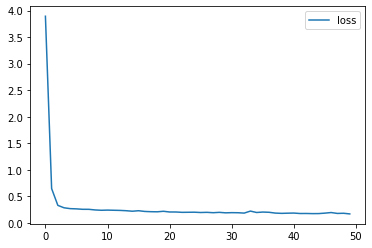

In [37]:
#plot the loss and validation loss of the dataset
history_df = pd.DataFrame(history.history)
plt.plot(history_df['loss'], label='loss')
# plt.plot(history_df['val_loss'], label='val_loss')

plt.legend()

In [53]:
#train_Input, val_Input, test_input = np.split(DF2, [int(.6 * len(DF2)), int(.8 * len(DF2))])
DF2shuffled = shuffle(DF2)
train_Input, test_input = np.split(DF2shuffled, [int(.8 * len(DF2))])

X_train = train_Input.iloc[:,:-1]
y_train = train_Input.iloc[:,-1]
# X_val_Input = val_Input.iloc[:,:-1]
# y_val= val_Input.iloc[:,-1]
X_test = test_input.iloc[:,:-1]
y_test = test_input.iloc[:,-1]

In [54]:
model1.evaluate(X_test, y_test, batch_size=10)

4/4 [==============================] - 0s 4ms/step - loss: 0.1250


0.12500695884227753

In [55]:
y_predict_dnn = model1.predict(X_test)

In [56]:
mean_squared_error(y_test, y_predict_dnn)

0.12500691592535157

In [57]:
idx   = np.argsort(y_test)
y_predict_dnn = y_predict_dnn.reshape(38,)
list1 = np.array(y_test)[idx]
list2 = np.array(y_predict_dnn)[idx]
fig = go.Figure()
fig.add_trace(go.Scatter(y=list1, name="y_test", line_shape='linear'))
fig.add_trace(go.Scatter(y=list2, name="y_predict_dnn", line_shape='linear'))
fig.update_layout(title_text='DNN MODEL RESULTS SORTED', title_x=0.5)
fig.show()

In [ ]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = sparse_categorical_crossentropy
no_classes = 100
no_epochs = 25
optimizer = Adam()
verbosity = 1
num_folds = 10

# # Load CIFAR-10 data
# (input_train, target_train), (input_test, target_test) = cifar10.load_data()

# # Determine shape of the data
# input_shape = (img_width, img_height, img_num_channels)

# # Parse numbers as floats
# input_train = input_train.astype('float32')
# input_test = input_test.astype('float32')

# # Normalize data
# input_train = input_train / 255
# input_test = input_test / 255

# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# # Merge inputs and targets
# inputs = np.concatenate((input_train, input_test), axis=0)
# targets = np.concatenate((target_train, target_test), axis=0)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  # Define the model architecture
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(no_classes, activation='softmax'))

  # Compile the model
  model.compile(loss=loss_function,
                optimizer=optimizer,
                metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

  # Generate generalization metrics
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')